<a href="https://colab.research.google.com/github/iris-kurapaty/PytorchLightning_Experiments/blob/main/ERA_Assignment_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/ERA V1/Assignment 10/src'

Mounted at /content/drive
/content/drive/My Drive/ERA V1/Assignment 10/src


In [2]:
! pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
  

In [3]:
!pip install torch-lr-finder

In [4]:
pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 10.7 MB/s eta 0:00:00


In [5]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 14.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38245 sha256=9c24dba0b0025846b1e9f6ca55381f3d1b1bcf46b7e75ce55767eab5ff747e41
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [18]:
%cd 'drive/My Drive/ERA V1/Assignment 10/src'

[Errno 2] No such file or directory: 'drive/My Drive/ERA V1/Assignment 10/src'
/content/drive/My Drive/ERA V1/Assignment 10/src


In [6]:
from __future__ import print_function
from pytorch_lightning import LightningModule, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchsummary import summary
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from model import *
from utils import *
from dataset import cifar10Dataset, get_loader
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torch_lr_finder import LRFinder
import gradio as gr
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

In [7]:
## Initializing some parameters
cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
AVAIL_GPUS

1

In [8]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class CustomBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomBlock, self).__init__()

        self.inner_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.res_block = BasicBlock(out_channels, out_channels)

    def forward(self, x):
        x = self.inner_layer(x)
        r = self.res_block(x)

        out = x + r

        return out

In [9]:
class LitNet(LightningModule):
  def __init__(self, max_lr):
    super().__init__()

    self.dropout = 0.1
    self.max_lr = max_lr

    self.criterion = nn.CrossEntropyLoss()
    self.accuracy = Accuracy(task='multiclass',num_classes=10)

    self.means = (0.4914, 0.4822, 0.4465)
    self.stds = (0.2470, 0.2435, 0.2616)

    self.train_transform =  A.Compose([
        A.Normalize(self.means, self.stds),
        A.PadIfNeeded(36,36),
        A.RandomCrop(height=32, width=32),
        A.HorizontalFlip(p=0.05),
        A.CoarseDropout(max_holes = 1, max_height=8, max_width=8, min_holes = 1, min_height=8, min_width=8, fill_value=self.means, mask_fill_value =None),
        ToTensorV2()])

    self.test_transform = A.Compose([
        A.Normalize(self.means, self.stds),
        ToTensorV2()])

    # Prep Layer input 32/1/1
    self.prep_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU()
    ) # output_size =32

    self.layer_1 = CustomBlock(in_channels=64, out_channels=128)

    self.layer_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=128,
            out_channels=256,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        ),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
    )

    self.layer_3 = CustomBlock(in_channels=256, out_channels=512)

    self.max_pool = nn.Sequential(nn.MaxPool2d(kernel_size=4))

    self.fc = nn.Linear(512, 10)

  def forward(self, x):
      x = self.prep_layer(x)
      x = self.layer_1(x)
      x = self.layer_2(x)
      x = self.layer_3(x)
      x = self.max_pool(x)
      x = x.view(x.size(0), -1)
      x = self.fc(x)
      return x

  def training_step(self, batch, batch_idx):
      x, y = batch
      logits = self.forward(x)
      loss = self.criterion(logits, y)

      self.log("train_loss", loss, prog_bar=True)
      return loss

  def validation_step(self, batch, batch_idx):
      x, y = batch
      logits = self.forward(x)
      loss = self.criterion(logits, y)
      preds = torch.argmax(logits, dim=1)
      self.accuracy(preds, y)

      # Calling self.log will surface up scalars for you in TensorBoard
      self.log("val_loss", loss, prog_bar=True)
      self.log("val_acc", self.accuracy, prog_bar=True)
      return loss

  def test_step(self, batch, batch_idx):
      # Here we just reuse the validation_step for testing
      return self.validation_step(batch, batch_idx)

  def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=0.03, weight_decay=1e-4)
      num_epochs = self.trainer.max_epochs
      scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.max_lr,
                                                      steps_per_epoch=self.trainer.estimated_stepping_batches, epochs=num_epochs,
                                                      pct_start=5/num_epochs, div_factor=100,
                                                      three_phase=False,final_div_factor=100,anneal_strategy='linear')

      lr_scheduler = {"scheduler": scheduler, "interval": "step"}
      return [optimizer], [lr_scheduler]

  #####################################
  ## DATA RELATED
  #####################################

  def prepare_data(self):
      # download
      cifar10Dataset(root = "./data", train=True, download=True)
      cifar10Dataset(root = "./data", train=False, download=True)

  def setup(self, stage=None):


      # Assign train/val datasets for use in dataloaders
      if stage == "fit" or stage is None:
          self.full_data = cifar10Dataset(root = "./data", train=True, transform=self.train_transform)
          self.train_data, self.val_data = random_split(self.full_data, [45000, 5000])

      # Assign test dataset for use in dataloader(s)
      if stage == "test" or stage is None:
          self.test_data = cifar10Dataset(root = "./data", train=False, transform=self.test_transform)

  def train_dataloader(self):
      return DataLoader(self.train_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True, pin_memory=True)

  def val_dataloader(self):
      return DataLoader(self.val_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True, pin_memory=True)

  def test_dataloader(self):
      return DataLoader(self.test_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True, pin_memory=True)

Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.87E-02


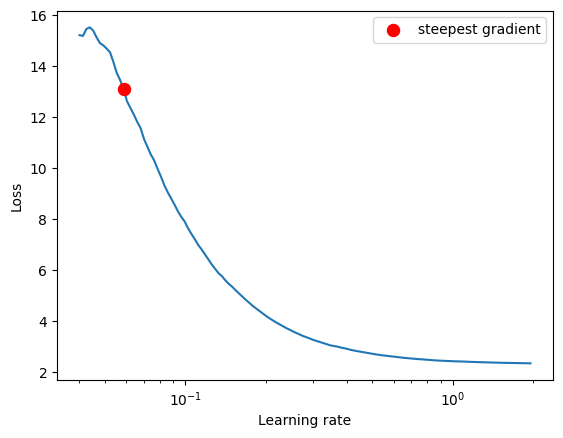

In [10]:
model = LitNet(0.1)
LEARNING_RATE = 0.03
WEIGHT_DECAY = 1e-4
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

train_set = cifar10Dataset(root = "./data", train=True, transform=model.train_transform)
# train dataloader
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True, pin_memory=True)

lr_finder2 = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder2.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder2.plot()
lr_finder2.reset()

In [15]:
## Try without 16 precision and check for accuracy?

In [45]:
model.layer_3.res_block.conv2

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [ ]:
model

In [11]:
model = LitNet(5.87E-02)
trainer = Trainer(
    # precision = 16,
    # gpus = AVAIL_GPUS,
    max_epochs = 25,
)
trainer.fit(model)
trainer.test()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type               | Params
--------------------------------------------------
0 | criterion  | CrossEntropyLoss   | 0     
1 | accuracy   | MulticlassAccuracy | 0     
2 | prep_layer | Sequential         | 1.9 K 
3 | layer_1    | CustomBlock        | 369 K 
4 | layer_2    | Sequential         | 295 K 
5 | layer_3    | CustomBlock        | 5.9 M 
6 | max_pool   | Sequential         | 0     
7 | fc         | Linear             | 5.1 K 
--------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.293    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/ERA V1/Assignment 10/src/lightning_logs/version_14/checkpoints/epoch=24-step=4400.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/ERA V1/Assignment 10/src/lightning_logs/version_14/checkpoints/epoch=24-step=4400.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.7912999987602234
        val_loss            0.6089878678321838
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.6089878678321838, 'val_acc': 0.7912999987602234}]

In [12]:
## Saving the Model
trainer.save_checkpoint('model.pth')

In [13]:
inv_normalize = transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
)
classes = ('plane', 'car', 'bird', 'cat',
          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [14]:
def mis_classified_images(model, device, test_loader):
  incorrect_examples = []
  incorrect_labels = []
  incorrect_pred = []
  for data,target in test_loader:

    data , target = data.to(device), target.to(device)
    model = model.to(device)
    output = model(data) # shape = torch.Size([batch_size, 10])
    pred = output.argmax(dim=1, keepdim=True) #pred will be a 2d tensor of shape [batch_size,1]
    idxs_mask = ((pred == target.view_as(pred))==False).view(-1)
    if idxs_mask.numel(): #if index masks is non-empty append the correspoding data value in incorrect examples
      incorrect_examples.append(data[idxs_mask].squeeze().cpu().numpy()) #
      incorrect_labels.append(target[idxs_mask].cpu().numpy())# #the corresponding target to the misclassified image
      incorrect_pred.append(pred[idxs_mask].squeeze().cpu().numpy()) ##the corresponiding predicted class of the misclassified image

  return incorrect_examples, incorrect_labels,incorrect_pred

In [15]:
test_loader = DataLoader(model.test_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True, pin_memory=True)
incorrect_examples, incorrect_labels,incorrect_pred = mis_classified_images(model, device, test_loader)

In [52]:
def display_gradcam(model, incorrect_examples, num_images, inv_normalize, transperancy, targets=None):
  # target_layers = [model.layer_2[-1]]
  target_layers = [model.layer_3.res_block.conv2]
  cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
  grad_cam_images = []
  # f, axes = plt.subplots(nrows=4, ncols=5, left=1, right=2)
  for i in range(num_images):
    # ax = axes.flat[i]
    input_tensor = torch.from_numpy(incorrect_examples[0][i])
    input_tensor = input_tensor.unsqueeze(0)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    img = input_tensor.squeeze(0).to('cpu')
    img = inv_normalize(img)
    rgb_img = np.transpose(img, (1, 2, 0))
    rgb_img = rgb_img.numpy()
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=transperancy)
    # plt.subplot(4, 5, i+1)
    # plt.imshow(visualization)
    # plt.axis('off')
    # plt.title("actual: %s\npredicted: %s" % (classes[incorrect_labels[0][i]], classes[incorrect_pred[0][i]]), fontsize=8)
    # plt.subplots_adjust(top=5, bottom=3, left=1, right=2)

    grad_cam_images.append(visualization)
  return grad_cam_images



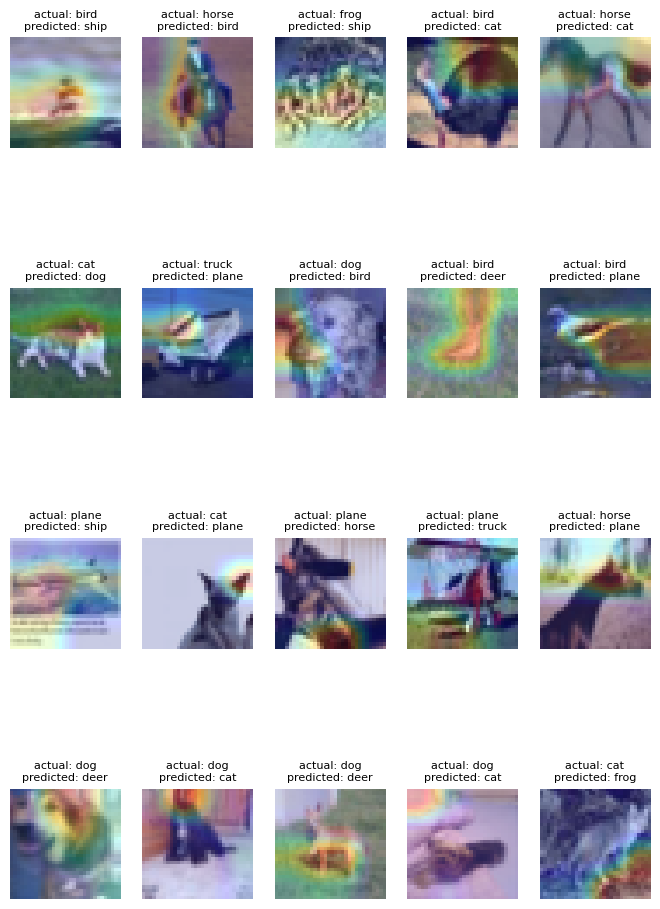

In [51]:
grad_cam_images = display_gradcam(model, incorrect_examples, 20, inv_normalize, 0.8)

In [22]:
def num_imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg= np.transpose(npimg, (1, 2, 0))
    return npimg

In [21]:
def plot_images(incorrect_examples, incorrect_labels,incorrect_pred, num_images):

  classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  for i in range(1, num_images+1):
    img = incorrect_examples[0][i-1]
    plt.subplot(4, 5, i)9
    plt.imshow(num_imshow(torch.from_numpy(img)))
    plt.axis('off')
    plt.title("actual: %s\npredicted: %s" % (classes[incorrect_labels[0][i-1]], classes[incorrect_pred[0][i-1]]), fontsize=8)
    plt.subplots_adjust(top=5, bottom=3, left=1, right=2)
  return

In [ ]:
def get_misclassified_data(model, device, test_loader):
  """
  Function to run the model on test set and return misclassified images
  :param model: Network Architecture
  :param device: CPU/GPU
  :param test_loader: DataLoader for test set
  """
  # List to store misclassified Images
  misclassified_data = []

  # Reset the gradients
  with torch.no_grad():
      # Extract images, labels in a batch
      for data, target in test_loader:

          # Migrate the data to the device
          data, target = data.to(device), target.to(device)

          # Extract single image, label from the batch
          for image, label in zip(data, target):

              # Add batch dimension to the image
              image = image.unsqueeze(0)

              # Get the model prediction on the image
              output = model(image)

              # Convert the output from one-hot encoding to a value
              pred = output.argmax(dim=1, keepdim=True)

              # If prediction is incorrect, append the data
              if pred != label:
                  misclassified_data.append((image, label, pred))
  return misclassified_data

In [20]:
len(incorrect_labels[1])

56

In [36]:
def trial(input_img, transparency):
    # transform = model.test_transform
    transform = transforms.ToTensor()
    org_img = input_img
    # input_img = transform(input_img)["image"]
    input_img = input_img.to(device)
    input_img = input_img.unsqueeze(0)
    print(input_img.shape)
    outputs = model(input_img)
    prediction = outputs.argmax(dim=1, keepdim=True)
    target_layers = [model.layer_2[-1]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    grayscale_cam = cam(input_tensor=input_img, targets=None)
    grayscale_cam = grayscale_cam[0, :]
    img = input_img.squeeze(0).to('cpu')
    img = inv_normalize(img)
    rgb_img = np.transpose(img, (1, 2, 0))
    rgb_img = rgb_img.numpy()
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=transparency)
    return classes[prediction[0].item()], visualization

In [37]:
data_test = next(iter(test_loader))
data, target = data_test[0], data_test[1]
class1, vis = trial(data[1], 0.7)

torch.Size([1, 3, 32, 32])


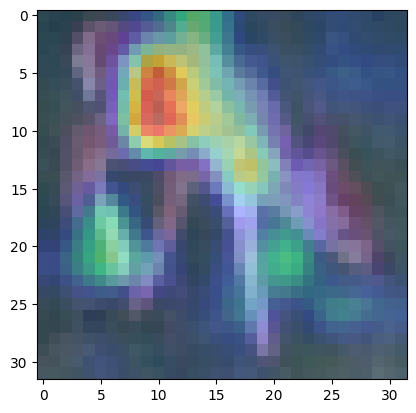

In [38]:
import matplotlib.pyplot as plt
plt.imshow(vis)

In [45]:
def inference(input_img, transparency):
    transform = transforms.ToTensor()
    org_img = input_img
    input_img = transform(input_img)
    input_img = input_img.to(device)
    input_img = input_img.unsqueeze(0)
    outputs = model(input_img)
    _, prediction = torch.max(outputs, 1)
    target_layers = [model.layer_2[-1]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    grayscale_cam = cam(input_tensor=input_img, targets=None)
    grayscale_cam = grayscale_cam[0, :]
    img = input_img.squeeze(0).to('cpu')
    img = inv_normalize(img)
    rgb_img = np.transpose(img, (1, 2, 0))
    rgb_img = rgb_img.numpy()
    #org_img/255
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=transparency)
    return classes[prediction[0].item()], visualization

demo = gr.Interface(inference, [gr.Image(shape=(32, 32)), gr.Slider(0, 1)], ["text", gr.Image(shape=(32, 32)).style(width=128, height=128)])
demo.launch()

<ipython-input-45-8a5669a0e574>:22: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  demo = gr.Interface(inference, [gr.Image(shape=(32, 32)), gr.Slider(0, 1)], ["text", gr.Image(shape=(32, 32)).style(width=128, height=128)])


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Done here
Keyboard interruption in main thread... closing server.


In [46]:
# how to get top n classes

In [48]:
input_img = data[1]
input_img = input_img.to(device)
input_img = input_img.unsqueeze(0)
outputs = model(input_img)
softmax = torch.nn.Softmax(dim=0)
o = softmax(outputs.flatten())
confidences = {classes[i]: float(o[i]) for i in range(10)}

In [95]:
confidences = {'plane': 0.00014240163727663457,
 'car': 5.5546184739796445e-05,
 'bird': 0.8555200695991516,
 'cat': 0.007787058595567942,
 'deer': 0.06538698822259903,
 'dog': 0.018702320754528046,
 'frog': 0.04180018603801727,
 'horse': 0.01056614238768816,
 'ship': 2.185500125051476e-05,
 'truck': 1.73962653207127e-05}

In [96]:
confidences = dict(sorted(confidences.items(), key=lambda x:x[1]))
top_class = list(confidences.items())[-3:]
top_class = dict(top_class)

In [97]:
top_class

{'frog': 0.04180018603801727,
 'deer': 0.06538698822259903,
 'bird': 0.8555200695991516}

In [88]:
confidences = sorted(confidences.items(), key=lambda x:x[1])

AttributeError: ignored

In [87]:
dict(confidences)

{'truck': 1.73962653207127e-05,
 'ship': 2.185500125051476e-05,
 'car': 5.5546184739796445e-05,
 'plane': 0.00014240163727663457,
 'cat': 0.007787058595567942,
 'horse': 0.01056614238768816,
 'dog': 0.018702320754528046,
 'frog': 0.04180018603801727,
 'deer': 0.06538698822259903,
 'bird': 0.8555200695991516}

In [75]:
va = list(confidences.items())[:3]
dict(va)

{'plane': 0.00014240163727663457,
 'car': 5.5546184739796445e-05,
 'bird': 0.8555200695991516}

In [32]:
missclassified_output = incorrect_examples[0][:3]

In [35]:
missclassified_output[0].shape

(3, 32, 32)

In [100]:
inv_normalize = transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
    )

classes = ('plane', 'car', 'bird', 'cat',
          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



def inference(grad_cam_flag, grad_num, input_img, num_class, transparency, target_num_layer, misclass_flag, misclass_num):
  grad_cam_images = []
  grad_cam_output = []
  missclassified_output = []

  if misclass_flag:
    missclassified_output = incorrect_examples[0][:misclass_num]
    missclassified_output = [inv_normalize(torch.from_numpy(missclassified_output[i])) for i in range(misclass_num)]
    missclassified_output = [np.transpose(missclassified_output[i], (1, 2, 0)) for i in range(misclass_num)]
    missclassified_output = [missclassified_output[i].numpy() for i in range(misclass_num)]

  if grad_cam_flag:
    transform = transforms.ToTensor()
    org_img = input_img
    input_img = transform(input_img)
    input_img = input_img.to(device)
    input_img = input_img.unsqueeze(0)
    outputs = model(input_img)
    softmax = torch.nn.Softmax(dim=0)
    o = softmax(outputs.flatten())
    confidences = {classes[i]: float(o[i]) for i in range(10)}
    _, prediction = torch.max(outputs, 1)
    target_layers = [model.layer_2[target_num_layer]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
    grayscale_cam = cam(input_tensor=input_img, targets=None)
    grayscale_cam = grayscale_cam[0, :]
    img = input_img.squeeze(0).to('cpu')
    img = inv_normalize(img)
    rgb_img = np.transpose(img, (1, 2, 0))
    rgb_img = rgb_img.numpy()
    grad_cam_output = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=transparency)
    # grad_cam_output.append(grad_cam_)

  if grad_cam_flag & grad_num>0:
    grad_cam_images = display_gradcam(model, incorrect_examples, grad_num, inv_normalize, 0.8)

  confidences = dict(sorted(confidences.items(), key=lambda x:x[1], reverse=True))
  top_class = list(confidences.items())[:num_class]
  top_class = dict(top_class)

  return top_class, grad_cam_images, grad_cam_output, missclassified_output

demo = gr.Interface(
    inference,
    inputs = [
        gr.Checkbox(label = 'Would you like to see GradCam images?'),
        gr.Slider(0,20, step=5, value= 3, label='If yes, how many GradCam Images'),
        gr.Image(shape=(32,32), label='Input Image to check GradCAM'),
        gr.Slider(1,10, step=1, value= 0, label='How many top classes would you like to see?'),
        gr.Slider(0,1, value= 0.5, label='Overlap Opacity of Image'),
        gr.Slider(-2,-1, value= -1, label='Which layer?'),
        gr.Checkbox(label = 'Would you like to see Missclassfied images?'),
        gr.Slider(1,10, step=1, value= 0, label='How many Missclassified images would you like to see?')
    ],
    outputs = [
        "label",
        gr.Gallery(label='GradCam images').style(width=128, height=128),
        gr.Image(shape=(32,32)).style(width=128, height=128),
        gr.Gallery(label='Missclassified Images').style(width=128, height=128)

    ],
    title = 'Displaying Grad Cam and MissClassified Images',
    description = 'Pick the following options to decide on outputs'
    # examples = [["dog.jpg", 0.7, -1],["deer.jpg", 0.8, -1]]
)
demo.launch()

<ipython-input-100-9989fc40ac5d>:67: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  gr.Gallery(label='GradCam images').style(width=128, height=128),
<ipython-input-100-9989fc40ac5d>:68: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  gr.Image(shape=(32,32)).style(width=128, height=128),
<ipython-input-100-9989fc40ac5d>:69: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  gr.Gallery(label='Missclassified Images').style(width=128, height=128)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>